In [17]:
import os
import numpy as np 
import cv2
import matplotlib.pyplot as plt 

Sources

https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html<br>
https://www.geeksforgeeks.org/image-registration-using-opencv-python/<br>
https://micasense.github.io/imageprocessing/Alignment.html<br>
https://micasense.github.io/imageprocessing/MicaSense%20Image%20Processing%20Tutorial%201.html<br>

<h1>Open Images and view the differences</h1>

In [18]:
wdir = '/mnt/c/DATA/PhG/Micasense/000/'

In [19]:
blue = cv2.imread(wdir +'IMG_0001_1.tif', -1)
green = cv2.imread(wdir +'IMG_0001_2.tif', -1) 
red = cv2.imread(wdir +'IMG_0001_3.tif', -1)
rededge = cv2.imread(wdir +'IMG_0001_4.tif', -1) 
nir = cv2.imread(wdir +'IMG_0001_5.tif', -1) 

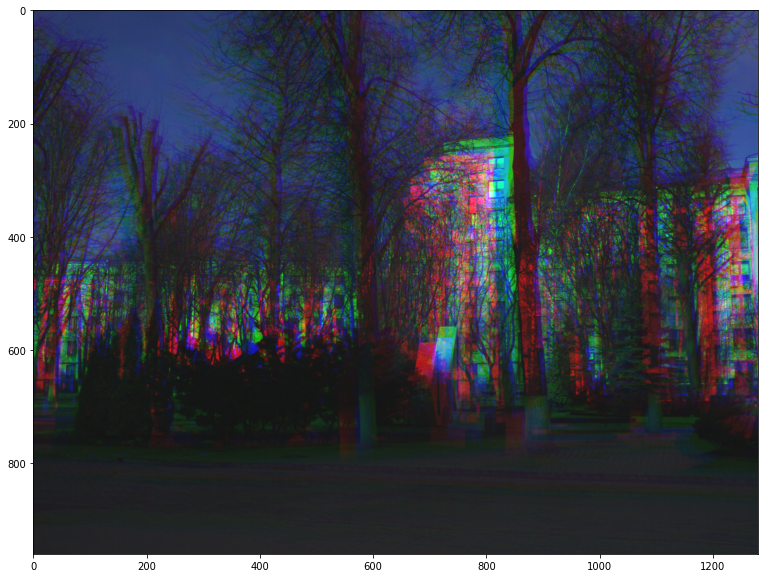

In [20]:
rgb_stack = np.stack((red//2**8, green//2**8,  blue//2**8), axis = 2)
plt.figure(figsize=(25, 10))
plt.imshow(rgb_stack)
plt.show()

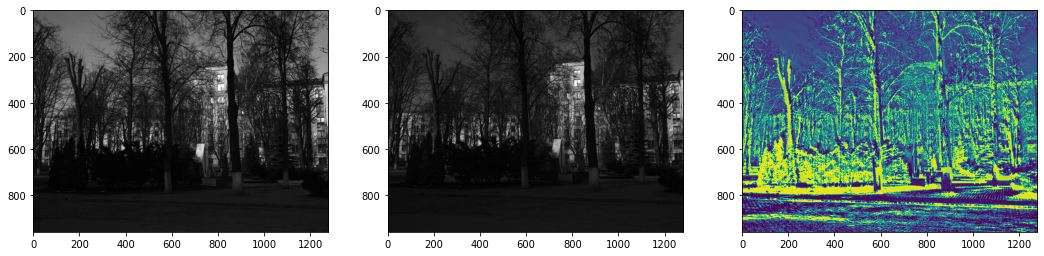

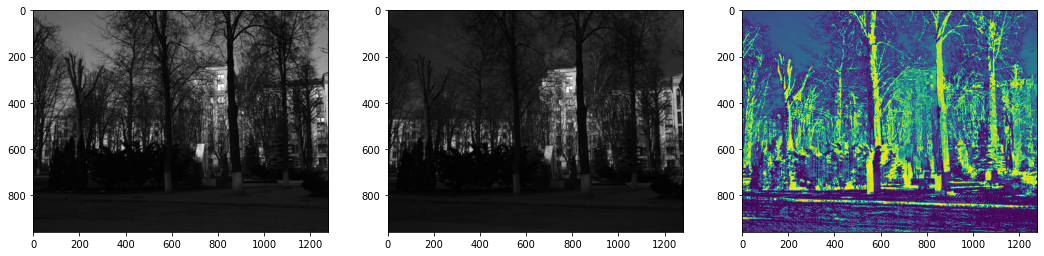

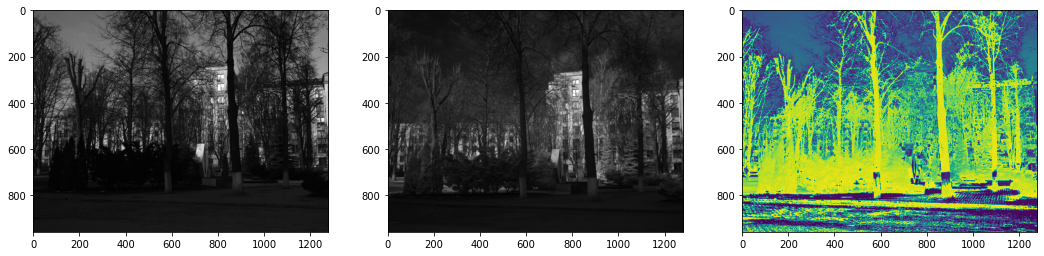

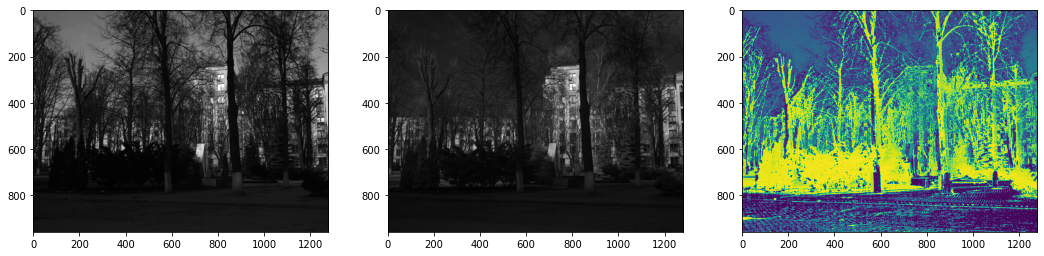

In [21]:
for img in [green, red, rededge, nir]:
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(blue, 'gray')
    plt.subplot(1, 3, 2)
    plt.imshow(img, 'gray')
    plt.subplot(1, 3, 3)
    diff = blue -img
    plt.imshow(diff)
    

<h1>SHIFT</h1>

In [22]:
wdir = '/mnt/c/DATA/PhG/Micasense/000/'

In [23]:
blue = cv2.imread(wdir +'IMG_0001_1.tif', -1)
green = cv2.imread(wdir +'IMG_0001_2.tif', -1) 
red = cv2.imread(wdir +'IMG_0001_3.tif', -1)
rededge = cv2.imread(wdir +'IMG_0001_4.tif', -1) 
nir = cv2.imread(wdir +'IMG_0001_5.tif', -1) 

In [24]:
blue.dtype

dtype('uint16')

In [25]:
def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=11)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=11)
 
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

In [26]:
def shift_image(base_image, warp_image, n_iter = 100000, inc = 1e-25):
    sz = base_image.shape
    
    # Define the motion model
    warp_mode = cv2.MOTION_TRANSLATION
    
    # Define matrice and initialize the matrix to identity
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    
    #Specify the number of iterations
    number_of_iterations = n_iter
    
    # Specify the threshold of the increment in the correlation coefficient between two iterations
    termination_eps = inc
    
    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)
    
    # Run the ECC algorithm. The results are stored in warp_matrix
    (cc, warp_matrix) = cv2.findTransformECC(get_gradient(base_image), get_gradient(warp_image), warp_matrix, warp_mode, criteria, inputMask = None, gaussFiltSize = 1)
    print(cc)
    # Use warpAffine for Translation, Euclidean and Affine
    image_shifted = cv2.warpAffine(warp_image, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    return(image_shifted)

In [27]:
green_shift = shift_image(blue, green)

0.7362567310717442


In [28]:
red_shift = shift_image(green_shift, red)

0.7734879916504027


In [29]:
rededge_shift = shift_image(red_shift, rededge)

0.7561801301937153


In [31]:
nir_shift = shift_image(rededge_shift, nir)

0.9183067128612421


<h1>Create color synthesis</h1>

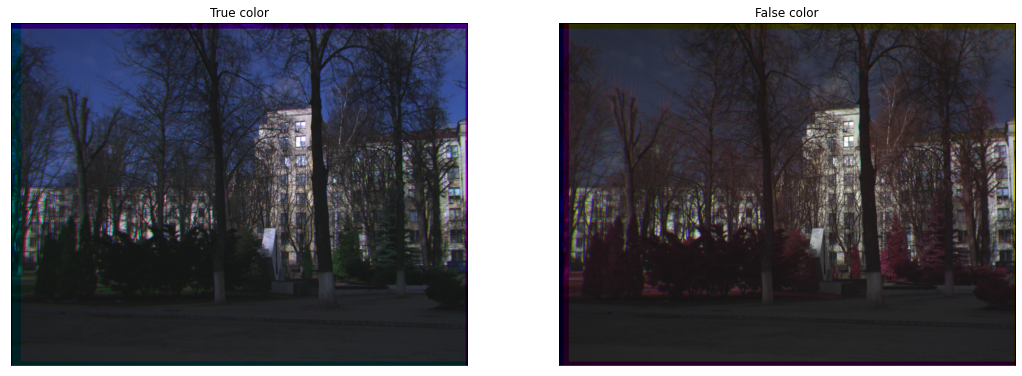

In [41]:
plt.figure(figsize = (18, 10))
plt.subplot(1,2,1)
plt.title('True color')
rgb_stack_transform = np.stack((red_shift//2**8, green_shift//2**8,  blue//2**8), axis = 2)
plt.imshow(rgb_stack_transform)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.title('False color')
nir_stack_transform = np.stack((nir_shift//2**8, red_shift//2**8, green_shift//2**8), axis = 2)
plt.imshow(nir_stack_transform)
plt.xticks([])
plt.yticks([])

plt.show()

In [44]:
R = cv2.equalizeHist((nir_shift//2**8).astype('uint8'))
G = cv2.equalizeHist((red_shift//2**8).astype('uint8'))
B = cv2.equalizeHist((green_shift//2**8).astype('uint8'))

In [45]:
nir_stack_transform_8bit_eq = np.stack((R, G, B), axis = 2)

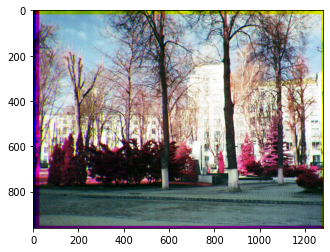

In [46]:
plt.imshow(nir_stack_transform_8bit_eq)

In [47]:
# Save the output. 
cv2.imwrite('/mnt/c/DATA/PhG/Micasense/000/test.tif', nir_stack_transform_8bit_eq) 

True